<a href="https://www.kaggle.com/code/jeffersonangelareche/graphs-regresion-model?scriptVersionId=185611813" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile

In [2]:
olympic_track_field_results = os.path.join('source','olympic-track-field-results.csv')
noc_regions = os.path.join('source','noc_regions.csv')
athlete_events = os.path.join('source','athlete_events.csv')

In [3]:
try:
    !kaggle datasets download -d heesoo37/120-years-of-olympic-history-athletes-and-results -p source/
    !kaggle datasets download -d jayrav13/olympic-track-field-results -p source/
    zipfile.ZipFile(os.path.join('source','120-years-of-olympic-history-athletes-and-results.zip')).extractall('source')
    zipfile.ZipFile(os.path.join('source','olympic-track-field-results.zip')).extractall('source')
    os.rename(os.path.join('source','results.csv'), os.path.join('source','olympic-track-field-results.csv'))
    os.remove(os.path.join('source','results.json'))

except:
    print('\033[91m' + 'Elimine los archivos de la carpeta source e intente de nuevo, ocurrió un problema al encontrar archivos existentes.' + '\033[0m')

Dataset URL: https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results
License(s): CC0-1.0
  0%|                                               | 0.00/5.43M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 5.43M/5.43M [00:00<00:00, 163MB/s]
Dataset URL: https://www.kaggle.com/datasets/jayrav13/olympic-track-field-results
License(s): unknown
  0%|                                               | 0.00/80.0k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 80.0k/80.0k [00:00<00:00, 39.7MB/s]


In [4]:
df_1 = pd.read_csv(olympic_track_field_results, on_bad_lines='skip')
df_2 = pd.read_csv(noc_regions, on_bad_lines='skip')
df_3 = pd.read_csv(athlete_events, on_bad_lines='skip')

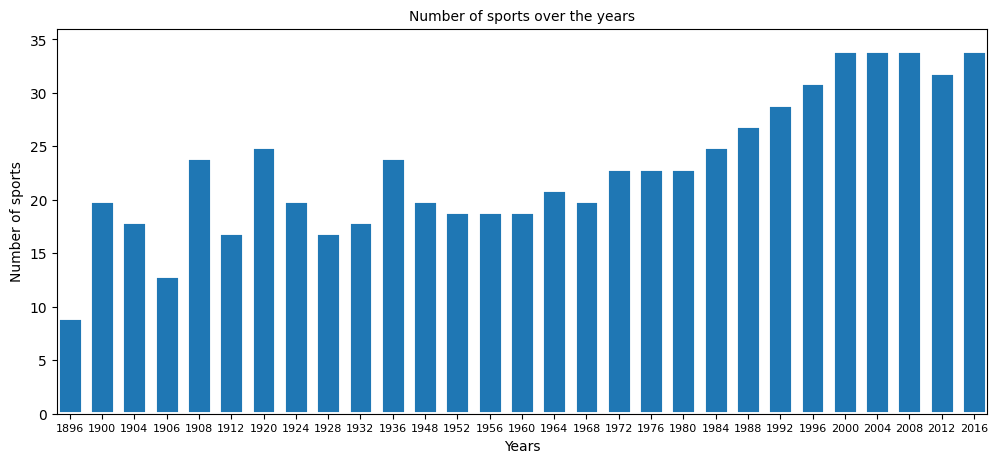

In [5]:
df_a2_img1 = df_3[df_3['Season']=='Summer'][['Sport','Year']].groupby('Year').agg({'Sport': ['nunique']}).reset_index().copy()
df_a2_img1.columns = ['Year','Sports']
df_a2_img1['Year'] = df_a2_img1['Year'].apply(lambda x: str(x))

fig, ax = plt.subplots(figsize=(12,5))
ax.bar(df_a2_img1['Year'], df_a2_img1['Sports'], data=df_a2_img1, width=0.8, edgecolor="w", linewidth=3.5)

ax.autoscale(enable=None, axis="x", tight=True)
plt.ylim(0,36)
plt.xticks(fontsize=8)
plt.title("Number of sports over the years", fontsize=10)
plt.ylabel("Number of sports", fontsize=10)
plt.xlabel("Years", fontsize=10)
plt.show()

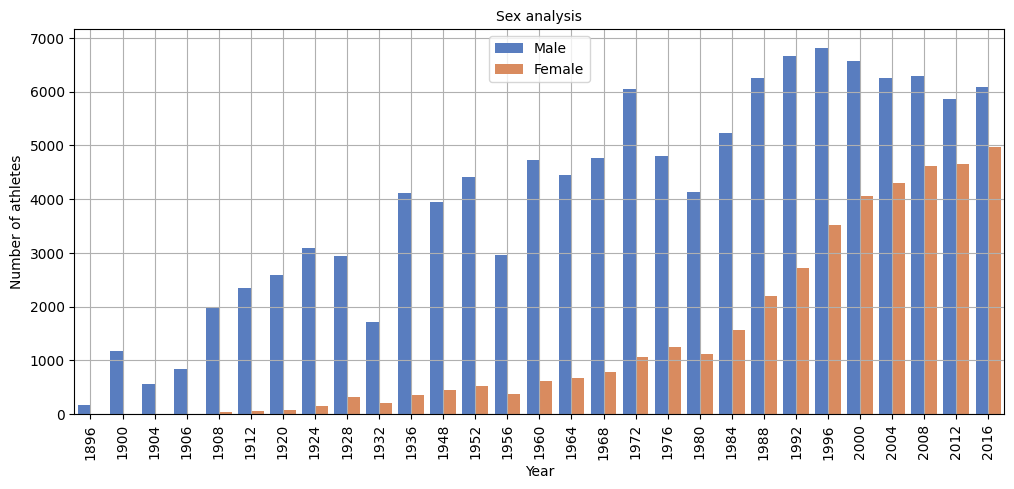

In [6]:
df_a2_img2 = df_3[(df_3['Season']=='Summer') & (df_3['Sport']!='Golf') & (df_3['Sport']!='Croquet')].copy()
df_a2_img2.loc[df_a2_img2['Sex'] == 'M', 'Sex'] = 'Male'
df_a2_img2.loc[df_a2_img2['Sex'] == 'F', 'Sex'] = 'Female'
df_a2_img2 = df_a2_img2.loc[:,["Year", "ID", "Sex"]].drop_duplicates().groupby(["Year", "Sex"]).size().reset_index().copy()
df_a2_img2.columns = ["Year","Sex","Count"]

fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x="Year", y="Count", data=df_a2_img2, hue="Sex", palette="muted") 
plt.title("Sex analysis", fontsize=10)
plt.ylabel("Number of athletes", fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.xticks(rotation=90)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.grid()
plt.show()

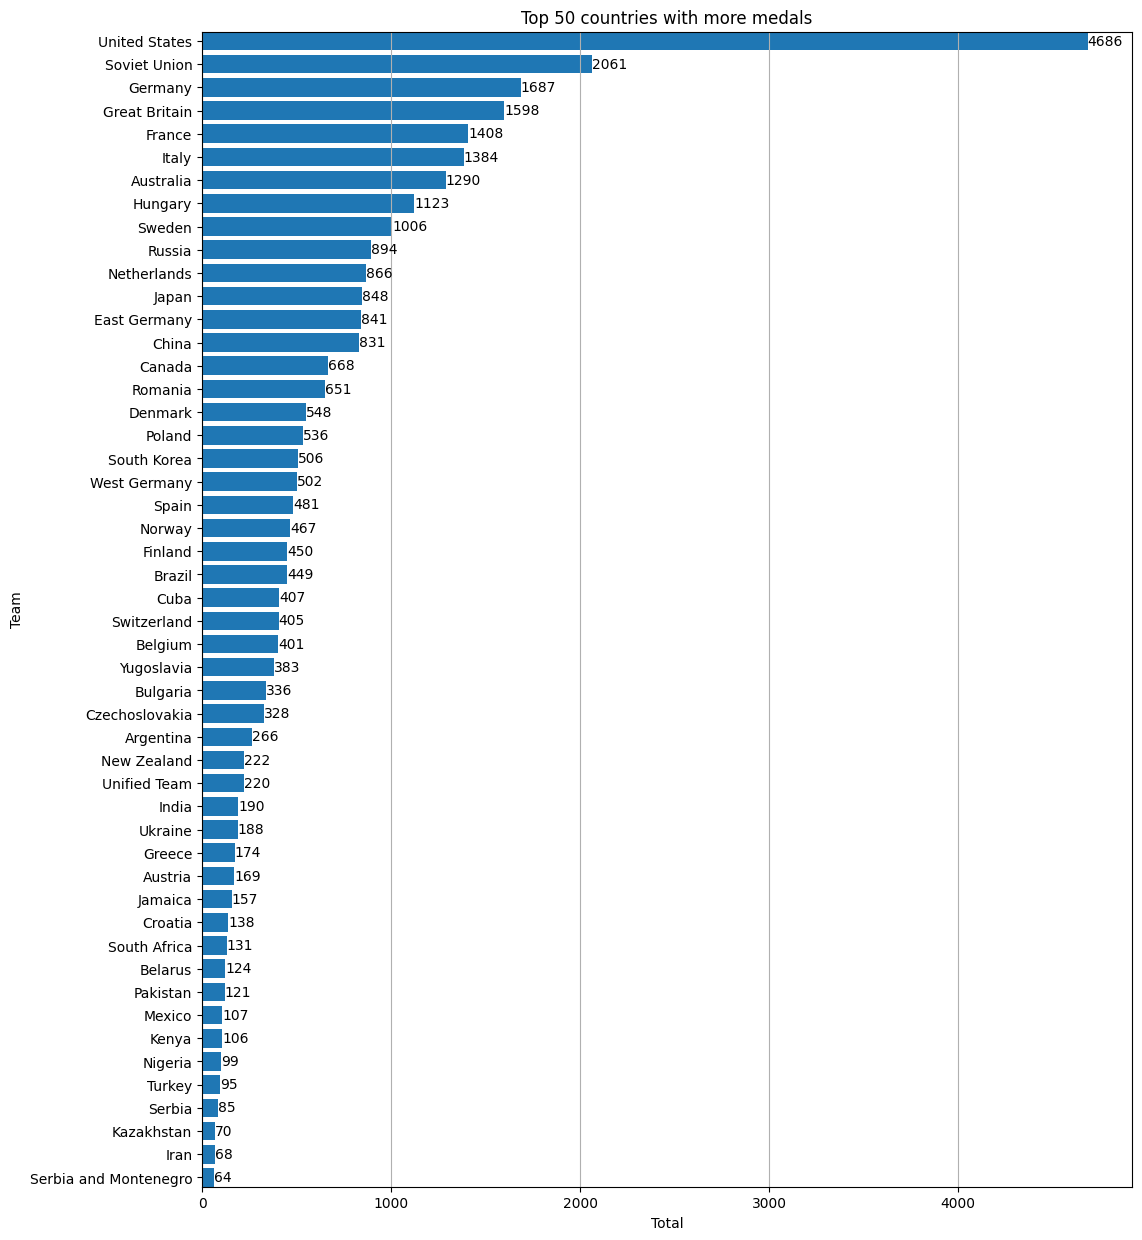

In [7]:
df_a2_img3 = df_3[(df_3['Season']=='Summer') & (df_3['Medal'].notnull())].copy()
ss_grouped = df_a2_img3.groupby(by='Team')['Team'].count().sort_values(ascending=False).head(50)

fig, ax = plt.subplots(figsize=(12,15))
my_barh = plt.barh(ss_grouped.index, ss_grouped.values)
ax.invert_yaxis()
ax.bar_label(my_barh)
ax.xaxis.grid()
plt.xlabel("Total") 
plt.ylabel("Team") 
plt.title("Top 50 countries with more medals")
plt.margins(y=0)
plt.show()

#### Building a regresion model based on dataset

In [8]:
list_events = ["Athletics Women's 100 metres", "Athletics Men's 100 metres"]
df_a3_results = df_1.copy()
df_a3_athletes = df_3.loc[(df_3['Event'].isin(list_events)) & (df_3['Medal'].notnull())].copy()

In [9]:
def medals(x):
    match x:
        case "Gold":
             return "G"
        case "Silver":
             return "S"
        case "Bronze":
             return "B"
            
df_a3_athletes['Event'] = df_a3_athletes['Event'].apply(lambda x: "100M Women" if x == list_events[0] else  "100M Men")
df_a3_athletes['Sex'] = df_a3_athletes['Sex'].apply(lambda x: 1 if x == "F" else 0)
df_a3_athletes['Medal'] = df_a3_athletes['Medal'].apply(lambda x: medals(x))
df_a3_results['Gender'] = df_a3_results['Gender'].apply(lambda x: 1 if x == "W" else 0)

In [10]:
columns_athletes = ['Sex', 'NOC', 'Year', 'Event', 'Medal']
columns_results = ['Gender', 'Nationality', 'Year', 'Event', 'Medal']
df_merged = pd.merge(df_a3_athletes, df_a3_results,  how='inner', left_on=columns_athletes, right_on = columns_results)
#display(df_merged)
df_data = df_merged.loc[:,['Age','Sex','Weight','Height','Result']].copy()
df_data = df_data[(df_data['Weight'].notnull()) & df_data['Result'].notnull()].reset_index(drop=True)
a = df_data.iloc[:,:4]
df_data[a.columns]= a.astype('Int64')
df_data['Result']= df_data['Result'].astype('Float64')

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn import metrics

linreg = LinearRegression()

In [12]:
feature_cols = ['Age', 'Sex', 'Weight','Height']
X = df_data[feature_cols]
y = df_data.Result

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [13]:
model = linreg.fit(X_train, y_train)

kf = KFold(n_splits=10, shuffle=False)
scores_train = cross_val_score(linreg, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
rmse_scores_train = -scores_train

for i in range(10):
    print(f'El error cuadratico medio en el split {i+1} de kfold es: {rmse_scores_train[i]}')
print(f'\nEl promedio de los errores cuadraticos medios con los datos de entrenamiento es: {rmse_scores_train.mean()}')

El error cuadratico medio en el split 1 de kfold es: 0.362364121745758
El error cuadratico medio en el split 2 de kfold es: 0.31405432076483525
El error cuadratico medio en el split 3 de kfold es: 0.5506947306077544
El error cuadratico medio en el split 4 de kfold es: 0.35606648236095584
El error cuadratico medio en el split 5 de kfold es: 0.28890236727355456
El error cuadratico medio en el split 6 de kfold es: 0.34480408608385876
El error cuadratico medio en el split 7 de kfold es: 0.3148286452384865
El error cuadratico medio en el split 8 de kfold es: 0.4663653201006738
El error cuadratico medio en el split 9 de kfold es: 0.6750997429719242
El error cuadratico medio en el split 10 de kfold es: 0.4151267208758151

El promedio de los errores cuadraticos medios con los datos de entrenamiento es: 0.4088306538023617


In [14]:
y_pred = pd.Series(data=model.predict(X_test), name='ResultPred').round(decimals=2)

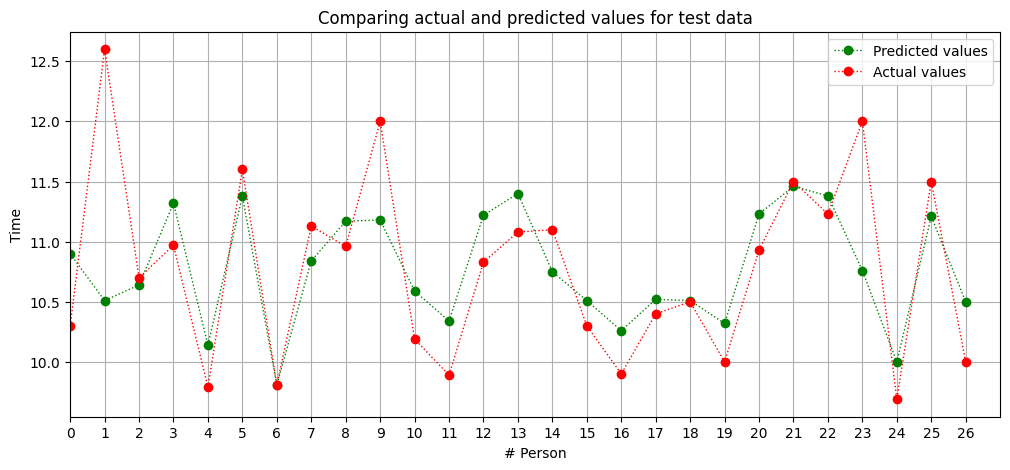

In [15]:
x_data = np.arange(27)
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(x_data,y_pred,'go:',label='Predicted values',linewidth=1)
ax.plot(x_data,y_test,'ro:',label='Actual values',linewidth=1)
ax.set_xticks(x_data)
ax.set_xticklabels(x_data)
ax.legend(loc='best') 
ax.set_xlim([0,27])
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
ax.set_title('Comparing actual and predicted values for test data')
ax.set_ylabel("Time")
ax.set_xlabel("# Person")
plt.grid()
plt.show()

In [16]:
print('Hint: 19, 0, 68, 181')
age = 19 #input('Introduce la edad: ')
sex = 0 #input('Introduce el sexo (0: Hombre, 1: Mujer): ')
weight = 68 #input('Introduce el peso (kg): ')
height = 181 #input('Introduce la altura (cm): ')

new_values = [[age,sex,weight,height]]
df_new_values = pd.DataFrame(data=new_values,columns=feature_cols)
print(f'Según el modelo escogido, el atleta con los datos introducidos hará el siguiente tiempo: {model.predict(df_new_values)[0]} segundos.')

Hint: 19, 0, 68, 181
Según el modelo escogido, el atleta con los datos introducidos hará el siguiente tiempo: 10.717218610839556 segundos.
